<a href="https://colab.research.google.com/github/vchantreauj/DSPortefolio/blob/master/cutie_chantreau.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Get the data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


if required, install tesseract for the OCR with the following lines :

!sudo apt install tesseract-ocr

!pip install pytesseract

In [ ]:
!sudo apt install tesseract-ocr

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-440
Use 'sudo apt autoremove' to remove it.
The following additional packages will be installed:
  tesseract-ocr-eng tesseract-ocr-osd
The following NEW packages will be installed:
  tesseract-ocr tesseract-ocr-eng tesseract-ocr-osd
0 upgraded, 3 newly installed, 0 to remove and 33 not upgraded.
Need to get 4,795 kB of archives.
After this operation, 15.8 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr-eng all 4.00~git24-0e00fe6-1.2 [1,588 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr-osd all 4.00~git24-0e00fe6-1.2 [2,989 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr amd64 4.00~git2288-10f4998a-2 [218 kB]
Fetched 4,795 kB in 1s (4,669 kB/s)
debconf: unable to initi

In [ ]:
!pip install pytesseract

  Created wheel for pytesseract: filename=pytesseract-0.3.4-py2.py3-none-any.whl size=13431 sha256=e5505a56026fc915468d1505527c4a7b0b2bb20208027a7bf7e9fb73a7d8faaa
  Stored in directory: /root/.cache/pip/wheels/63/2a/a0/7596d2e0a73cf0aeffd6f6170862c4e73f3763b7827e48691a
Successfully built pytesseract


In [ ]:
import numpy as np
import pandas as pd
import math
import skimage.io as skio
import skimage.viewer as skview
#import skimage.measure as skmeas
from skimage.io import imread_collection
import matplotlib.pyplot as plt
import pytesseract
#from matplotlib.backends.qt_compat import QtWidgets, QtCore, QtGui

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: UserWarning: Viewer requires Qt
  """


In [ ]:
from skimage.filters import threshold_otsu, threshold_local
from skimage.color import rgb2gray
import skimage.feature

In [ ]:
pd.options.display.max_columns = None
pd.options.display.max_rows = None

In [ ]:
receipt_dir = 'drive/My Drive/DataScience/Youngapp/*.jpg'
#creating a collection with the available receipt images
receipt = imread_collection(receipt_dir)

In [ ]:
receipt[0]

# Apply OCR method to transform each receipt into a grid of text, preserving text relative spacial relationship
1. Preprocess image
2. Get all receipt OCR (OCR_receipt array) and generate grid of text for each receipt

## Preprocess receipt images

To enhance the quality of tesseract OCR output, the image need to be process.
1. Obtain the grayscale image
2. Crop (function crop_image_brightness or crop_image_edges)
3. Binarize

In [ ]:
# crop image according to the brightness: cut when the total value of the pixel from one row 
# (or one col) exeed a threshold (= is bright enought)
# this threshold is relative to the number of pixel of the row or col and the percentage perc
def crop_image_brightness(img,tol=0.5,perc=0.3):
    # img is image data
    # tol  is tolerance
    # perc is the white threshold percentage tolerated
    tol = img.max()*tol
    mask = img>tol
    rowsum = mask.sum(axis=1) # sum per rows
    colsum = mask.sum(axis=0) # sum per cols
    if np.where(rowsum > int(len(colsum)*0.45))[0].size > 0:
      fromrow = np.where(rowsum > int(len(colsum)*perc))[0][0]
    else:
      fromrow = 0
    if np.where(rowsum[::-1] > int(len(colsum)*perc))[0].size > 0:
      torow = len(rowsum) - np.where(rowsum[::-1] > int(len(colsum)*perc))[0][0]
    else:
      torow = len(colsum)
    if np.where(colsum > int(len(rowsum)*perc))[0].size > 0: 
      fromcol = np.where(colsum > int(len(rowsum)*perc))[0][0]
    else:
      fromcol = 0
    if np.where(colsum[::-1] > int(len(rowsum)*perc))[0].size > 0: 
      tocol = len(colsum) - np.where(colsum[::-1] > int(len(rowsum)*perc))[0][0]
    else:
      tocol = len(rowsum)
    # if the resulting bounds are too close to each other, the image will be too shrinked
    # the edge detection may not be OK, so do not crop    
    if (torow - fromrow) < 0.4*len(colsum):
      fromrow = 0
      torow = len(colsum)
      #print('crop width KO')
    if (tocol - fromcol) < 0.4*len(rowsum):
      fromcol = 0
      tocol = len(rowsum)
      #print('crop height KO')    
    return img[fromrow:torow, fromcol:tocol]

In [ ]:
# crop the image thank to the edges:
# assess edges and use this mask to choose the row (or the columns) 
# which pixel's sum is superior to a threshold tresh (so there is a lot of white pixel, indicating an edge)
# because the edge is not perfectly horizontal (or vertical), 
# we use a sliding windows to work by bunch of rows (or colums)
def crop_image_edges(img, perc_thresh=0.7, perc_windows=0.03):
  edges = skimage.feature.canny(image=img)
  rowsum = edges.sum(axis=1) # sum per rows
  colsum = edges.sum(axis=0) # sum per cols
  windows_row = round(perc_windows*len(colsum))
  windows_col = round(perc_windows*len(rowsum))
  nbcol = len(rowsum)
  nbrow = len(colsum)
  fromrow = 0
  torow = nbcol
  fromcol = 0
  tocol = nbrow
  i = 0
  #for i in range(nbcol-windows_row):
  while ((fromrow == 0) or (torow == nbcol)) and (i < round(nbcol*0.6-windows_row)):
    if (fromrow == 0) and (rowsum[i:i+windows_row].sum() > int(nbrow*perc_thresh)):
      # crop at the middle of the sliding windows
      fromrow = round(i+windows_row*0.5)
    if (torow == nbcol) and (rowsum[::-1][i:i+windows_row].sum() > int(nbrow*perc_thresh)):
      torow = nbcol - round(i+windows_row*0.5)
    i+=1
  i = 0  
  while ((fromcol == 0) or (tocol == nbrow)) and (i < round(nbrow*0.6-windows_col)):
    if (fromcol == 0) and (colsum[i:i+windows_col].sum() > int(nbcol*perc_thresh)):
      fromcol = round(i+windows_row*0.5)
    if (tocol == nbrow) and (colsum[::-1][i:i+windows_col].sum() > int(nbcol*perc_thresh)):
      tocol = nbrow - round(i+windows_row*0.5)
    else:
      tocol = nbrow
    i += 1
  # if the resulting bounds are too close to each other, the image will be too shrinked
  # the edge detection may not be OK, so do not crop    
  if (torow - fromrow) < 0.4*nbrow:
    fromrow = 0
    torow = nbcol
    #print('crop width KO')
  if (tocol - fromcol) < 0.4*nbcol:
    fromcol = 0
    tocol = nbrow
    #print('crop height KO')
  return img[fromrow:torow, fromcol:tocol]

In [ ]:
def get_nb_word_from_OCR(bin_im):
  extracted_text = pytesseract.image_to_string(bin_im)
  splits = extracted_text.lower().splitlines()
  return (sum([len(splits[i].split(' ')) for i in range(len(splits))]), splits)

In [ ]:
# the best cropping method is the one who maximise the OCR result
# the OCR result is assess by the number of word detected
# and choose between crop_image_brightness or crop_image_edges
# bin indicates how the threshold is assess for the binarization
# bin = 'local', use local threshold
# bin = 'otsu', use global otsu threshold
# blocksize (only for bin = 'local') size of the block to assess the local threshold
# offset (only for bin = 'local') substract to the local mak
def get_best_OCR(img, bin='local', block_size=35, offset=0.1):
  nb_text_edges = 0
  nb_text_b = 0
  grayscale = rgb2gray(img)
  # crop according to brightness
  crop_b = crop_image_brightness(grayscale)
  if bin == 'local':
    # binarize image with adaptative threshold (default)
    ad_thresh = threshold_local(crop_b, block_size, offset=offset)
    bin_im = crop_b > ad_thresh
  else:
    # binarize image, adjust otsu treshold for image with not enought contrast (light background)
    thresh = min(threshold_otsu(crop_b), crop_b.mean())
    bin_im = crop_b > thresh
  # apply OCR
  nb_text_b, extracted_b = get_nb_word_from_OCR(bin_im)

  # crop according to edges
  crop_edges = crop_image_edges(grayscale)  
  if bin == 'local':
    # binarize image with adaptative threshold
    ad_thresh = threshold_local(crop_edges, block_size, offset=offset)
    bin_im_edges = crop_edges > ad_thresh
  else:
    # binarize image, adjust otsu treshold for image with not enought contrast (light background)
    thresh = min(threshold_otsu(crop_edges), crop_edges.mean())
    bin_im_edges = crop_edges > thresh  
  # apply OCR
  nb_text_edges, extracted_edges = get_nb_word_from_OCR(bin_im_edges)

  if nb_text_edges > nb_text_b:
    #print("best is edges", nb_text_edges, nb_text_b)
    return get_ocr_nona(bin_im_edges, extracted_edges)
  else:
    #print("best is contrast", nb_text_edges, nb_text_b)
    return get_ocr_nona(bin_im, extracted_b)


In [ ]:
# get the rows number of each text from the receipt
def get_text_index(text):
  # if a word is present several time, take and delete the first occurence each time
  # since the dataframe ocr_receipt will be sorted
  global splits
  for i in range(len(splits)):
    if (text.lower() in splits[i]):
      splits[i] = splits[i].replace(text.lower(), '')
      return i
    i += 1
  return 0

In [ ]:
# get OCR dataframe 
# drop all na text values
# add true lines number from extracted_text
def get_ocr_nona(bin_im, extracted_text_splits):
  OCR_receipt = pytesseract.image_to_data(bin_im, output_type='data.frame').dropna()
  # remove empty string for 'text' value
  OCR_receipt['text'] = OCR_receipt['text'].replace(r'^\s*$', np.nan, regex=True)
  # filter out low confidence text
  OCR_receipt = OCR_receipt[OCR_receipt['conf']>0].dropna()
  # get true line index ("line_num" from image_to_data depends on the "block_num") 
  OCR_receipt.sort_values(by=['top','width'], inplace=True)
  #extracted_text = pytesseract.image_to_string(bin_im)
  global splits
  splits = extracted_text_splits
  OCR_receipt['line'] = 0
  OCR_receipt['line'] = OCR_receipt.apply(lambda row: get_text_index(row['text']), axis=1)
  
  return OCR_receipt

## Get OCR and grid text

Get the grid with text position preserving the original spacial relationship among texts

In [ ]:
low_quality_receipt = []
grid_receipt = []
# target is a grid of 83 rows * 15 columns
# these values were chosen according to the max rows and columns number amond the 200 receipt (see Annexe)
nblines = 83
nbcols = 15
for i in range(len(receipt)):
#for i in range(110,111):
  if not i in low_quality_receipt:
    print(i)
    OCR_receipt = get_best_OCR(receipt[i])
    if OCR_receipt.shape[0] > 0:
      OCR_receipt['xcenter'] = OCR_receipt['left'] + 0.5*OCR_receipt['width']
      # normalize to a standard output target grid
      OCR_receipt['line'] = round(nblines*OCR_receipt['line']/max(OCR_receipt['line']))
      OCR_receipt['col'] = round(nbcols * (OCR_receipt['xcenter'])/max(OCR_receipt['xcenter']))
      df = pd.DataFrame(index=range(nblines+1), columns=range(nbcols+1))

      for j in range(len(OCR_receipt)):
        df.iloc[int(OCR_receipt.iloc[j]['line']),int(OCR_receipt.iloc[j]['col'])] = OCR_receipt.iloc[j]['text'].lower()
      grid_receipt.append(df.values)
    else:
      low_quality_receipt.append(i)
grid_receipt = np.array(grid_receipt)

In [ ]:
for i in range(len(grid_receipt)):
  print('-------------',i,'-------------')
  print(pd.DataFrame(grid_receipt[i]).tail(20))

In [ ]:
pd.DataFrame(grid_receipt[64])

# Extract text information thanks to CNN to predict the amount from a receipt

1. Label total amount in y: for each grid, a grid of the same size will map the text grid, 0 for text of no interest, 1 for the amount value.
Shape of y : nb_receipt (200), nb row in the target grid, nb columns in the target grid
2. Split set into training set receipt and test set receipt
3. Apply CNN model

## Map labels for each grid

In [ ]:
# the receipt with quality good enought will be selected for the training
# those with an unreadable amount are rejected (array low_quality_receipt)
labels = {0:[[None,None]], 1:[[49,11]], 2:[[None,None]], 3:[[None,None]], 4:[[66,13]], 5:[[69,11]], 6:[[None,None]], 7:[[69,12]], 8:[[52,10]], 9:[[None,None]],
          10:[[64,14]],11:[[51,14]],12:[[62,14]], 13:[[None,None]], 14:[[76,13]], 15:[[76,13]], 16:[[76,14]], 17:[[66,14]], 18:[[None,None]], 19:[[None,None]],
          20:[[61,13]], 21:[[83,15]], 22:[[None,None]], 23:[[67,12]], 24:[[51,11]], 25:[[None,None]], 26:[[None,None]], 27:[[63,11]], 28:[[None,None]], 29:[[75,15]],
          30:[[None,None]], 31:[[67,14]], 32:[[47,14]], 33:[[55,11],[55,12],[55,13]], 34:[[None,None]], 35:[[None,None]], 36:[[53,11]], 37:[[38,14]], 38:[[72,14]], 39:[[None,None]],
          40:[[None,None]], 41:[[None,None]], 42:[[83,14]], 43:[[None,None]], 44:[[None,None]], 45:[[63,12]], 46:[[78,15]], 47:[[None,None]], 48:[[67,15]], 49:[[None,None]],
          50:[[None,None]],51:[[61,13]],52:[[83,15]], 53:[[None,None]], 54:[[None,None]], 55:[[None,None]], 56:[[None,None]], 57:[[None,None]], 58:[[None,None]], 59:[[63,14]],
          60:[[71,14]],61:[[41,13]],62:[[None,None]], 63:[[None,None]], 64:[[None,None]], 65:[[61,14]], 66:[[None,None]], 67:[[None,None]], 68:[[None,None]], 69:[[None,None]],
          70:[[None,None]],71:[[68,13],[68,14],[68,15]],72:[[None,None]], 73:[[None,None]], 74:[[67,14]], 75:[[65,13]], 76:[[78,15]], 77:[[83,15]], 78:[[65,13]], 79:[[71,13]],
          80:[[73,14]],81:[[59,15]],82:[[57,13]], 83:[[None,None]], 84:[[78,14]], 85:[[51,13]], 86:[[73,13]], 87:[[None,None]], 88:[[None,None]], 89:[[79,14]],
          90:[[None,None]],91:[[80,15]],92:[[64,14]], 93:[[70,13]], 94:[[None,None]], 95:[[None,None]], 96:[[73,13]], 97:[[79,13]], 98:[[72,13]], 99:[[67,14]],
          100:[[None,None]],101:[[79,15]],102:[[78,15]], 103:[[77,14]], 104:[[None,None]], 105:[[83,15]], 106:[[None,None]], 107:[[None,None]], 108:[[80,15]], 109:[[68,13]],
          110:[[46,12]],111:[[None,None]],112:[[None,None]], 113:[[60,14]], 114:[[None,None]], 115:[[None,None]], 116:[[None,None]], 117:[[None,None]], 118:[[None,None]], 119:[[None,None]],
          120:[[74,15]],121:[[83,15]],122:[[83,15]], 123:[[83,13]], 124:[[73,14]], 125:[[69,15]], 126:[[56,14]], 127:[[76,14]], 128:[[78,15]], 129:[[69,13]],
          130:[[58,12]],131:[[57,10]],132:[[73,15]], 133:[[60,13]], 134:[[None,None]], 135:[[None,None]], 136:[[65,13]], 137:[[None,None]], 138:[[69,15]], 139:[[None,None]],
          140:[[54,14]],141:[[57,12]],142:[[None,None]], 143:[[59,14]], 144:[[70,10]], 145:[[44,13]], 146:[[77,15]], 147:[[71,13]], 148:[[66,15]], 149:[[None,None]],
          150:[[None,None]],151:[[None,None]],152:[[None,None]], 153:[[None,None]], 154:[[63,13]], 155:[[64,12]], 156:[[None,None]], 157:[[56,11]], 158:[[None,None]], 159:[[66,14]],
          160:[[None,None]],161:[[65,15]],162:[[83,14]], 163:[[75,13],[75,14],[75,15]], 164:[[None,None]], 165:[[74,14]], 166:[[None,None]], 167:[[None,None]], 168:[[53,15]], 169:[[None,None]],
          170:[[78,10]],171:[[71,15]],172:[[None,None]], 173:[[62,14]], 174:[[55,13]], 175:[[46,15]], 176:[[None,None]], 177:[[71,15]], 178:[[None,None]], 179:[[78,11]],
          180:[[None,None]],181:[[83,12]],182:[[None,None]], 183:[[61,14]], 184:[[76,14]], 185:[[79,15]], 186:[[None,None]], 187:[[60,12]], 188:[[75,15]], 189:[[53,12]],
          190:[[76,11]],191:[[71,14]],192:[[None,None]], 193:[[77,13]], 194:[[None,None]], 195:[[69,12]], 196:[[None,None]], 197:[[None,None]], 198:[[73,12]], 199:[[83,13]]}   

In [ ]:
len(grid_receipt) 

116

Generate y grids from labels

Remove from the set all receipt where the amount is unreadable

In [ ]:
done_receipt = [i for i in range(200) if i not in low_quality_receipt]
index_to_del = []
y = []
for i in labels.keys():
  if i not in low_quality_receipt:
    df = pd.DataFrame(index=range(nblines+1), columns=range(nbcols+1), data=0)
    if not pd.isnull(labels[i][0][0]):
      for j in range(len(labels[i])):
        df.iloc[labels[i][j][0],labels[i][j][1]] = 1
      y.append(df.values)
    else:
      low_quality_receipt.append(i)
      index_to_del.append(done_receipt.index(i))  
grid_receipt = np.delete(grid_receipt, index_to_del, axis=0)    
y = np.array(y)

## CNN Model
input is the target grid of shape( nblines, nbcols) containing word in respect to their relative position on the receipt

Embedding leads to shape (nblines, nbcols, vector_size) where vector_size is the vector_size of the embedded words.

The model needs to predict the cells of the grid which contains the amount, corresponding to a grid of the same shape as the input, with the labels.
Since we are only interesting in finding one kind of object, the target is binary: 0, not an amount, 1, is an amount (sigmoid activation).

The output is of shape (nblines, nbcols).


In [ ]:
import keras
from keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split
from keras.layers import Convolution2D
from keras.layers import Dropout
from keras.layers import Dense
from keras.layers import Concatenate
from keras.layers import Embedding, Input, Reshape
from keras.models import Model
from numpy import zeros

Using TensorFlow backend.


### Tokenize grid text for the 1rst layer: word embedding

In [ ]:
# type array to type list to allow tokenization of grid_receipt
grid_receipt_list = list(grid_receipt)
for i in range(len(grid_receipt_list)):
  grid_receipt_list[i] = list(grid_receipt_list[i])
  for j in range(len(grid_receipt_list[i])):
    grid_receipt_list[i][j] = list(grid_receipt_list[i][j])

In [ ]:
t = Tokenizer(lower=False)
for i in range(len(grid_receipt_list)):
  t.fit_on_texts(grid_receipt_list[i])
vocab_size = len(t.word_index) + 1

In [ ]:
encoded = []
for i in range(len(grid_receipt_list)):
  encoded_docs = t.texts_to_sequences(grid_receipt_list[i])
  encoded.append(encoded_docs)

### Get the training and test set

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(encoded, y, random_state=29, test_size=0.2)

### Construct the model

In [ ]:
# add_n_conv: add n convolution layers to the model
# padding = same so the shape is conserved, required to map the grid at the end
def add_n_conv(n, input_name, filters=32,kernel_size=(2,3), dilation_rate=1): # (3,5)
  while n > 0:
    input_name = Convolution2D(filters=filters,kernel_size=kernel_size,padding="same",activation='relu', dilation_rate= dilation_rate)(input_name)
    n -= 1
  return input_name

In [ ]:
word_input=Input(shape=(nblines+1,nbcols+1),dtype='float64')  
word_embedding = Embedding(input_dim=vocab_size,output_dim=128,input_length=(nblines+1,nbcols+1))(word_input)
dropout_layer = Dropout(0.9)(word_embedding)
output_layer_conv64 = add_n_conv(3, dropout_layer, filters=64, kernel_size=(2,3))
# concatenate to have the "raw" text information with the relative positions information
output_concat = Concatenate()([output_layer_conv64, word_embedding]) 
# sigmoid since we only have the class to predict: 0, none, 1, amount
output_layer_d1 = Dense(units=1, activation='sigmoid', use_bias=True, kernel_initializer='glorot_uniform')(output_concat)
output_layer = Reshape((nblines+1,nbcols+1))(output_layer_d1)
model = Model(word_input,output_layer) 

In [ ]:
model.compile(optimizer=keras.optimizers.Adam(lr=1e-3),loss='binary_crossentropy' ,metrics=['acc'])

In [ ]:
print(model.summary())

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 84, 16)       0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 84, 16, 128)  514048      input_1[0][0]                    
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 84, 16, 128)  0           embedding_1[0][0]                
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 84, 16, 64)   49216       dropout_1[0][0]                  
____________________________________________________________________________________________

In [ ]:
model.fit(np.array(X_train),np.array(y_train),epochs=60,validation_data=(np.array(X_test), np.array(y_test)))

### Test the model after training

In [ ]:
# show the grid text (grid_data) from the receipt
# colored according to the predicted probabilities pcolor
# the darker, the less likely
def grid2table(grid_data, pcolor):
  colours = plt.cm.Wistia(pcolor*255)
  fig, ax = plt.subplots()
  # hide axes
  fig.patch.set_visible(False)
  ax.axis('off')
  ax.axis('tight')
  table = ax.table(cellText=grid_data, rowLabels = range(nblines+1), colLabels=range(nbcols+1), loc='center', cellColours=colours)
  table.auto_set_font_size(False)
  table.set_fontsize(14)
  table.scale(4, 1.5)
  plt.show()

In [ ]:
y_pred = model.predict(np.array(X_test))

In [ ]:
# get the original text
def untokenize_receipt(r):
  untok = lambda x: t.index_word[x]  
  for i in range(len(r)):
    r[i] = list(map(untok, r[i]))

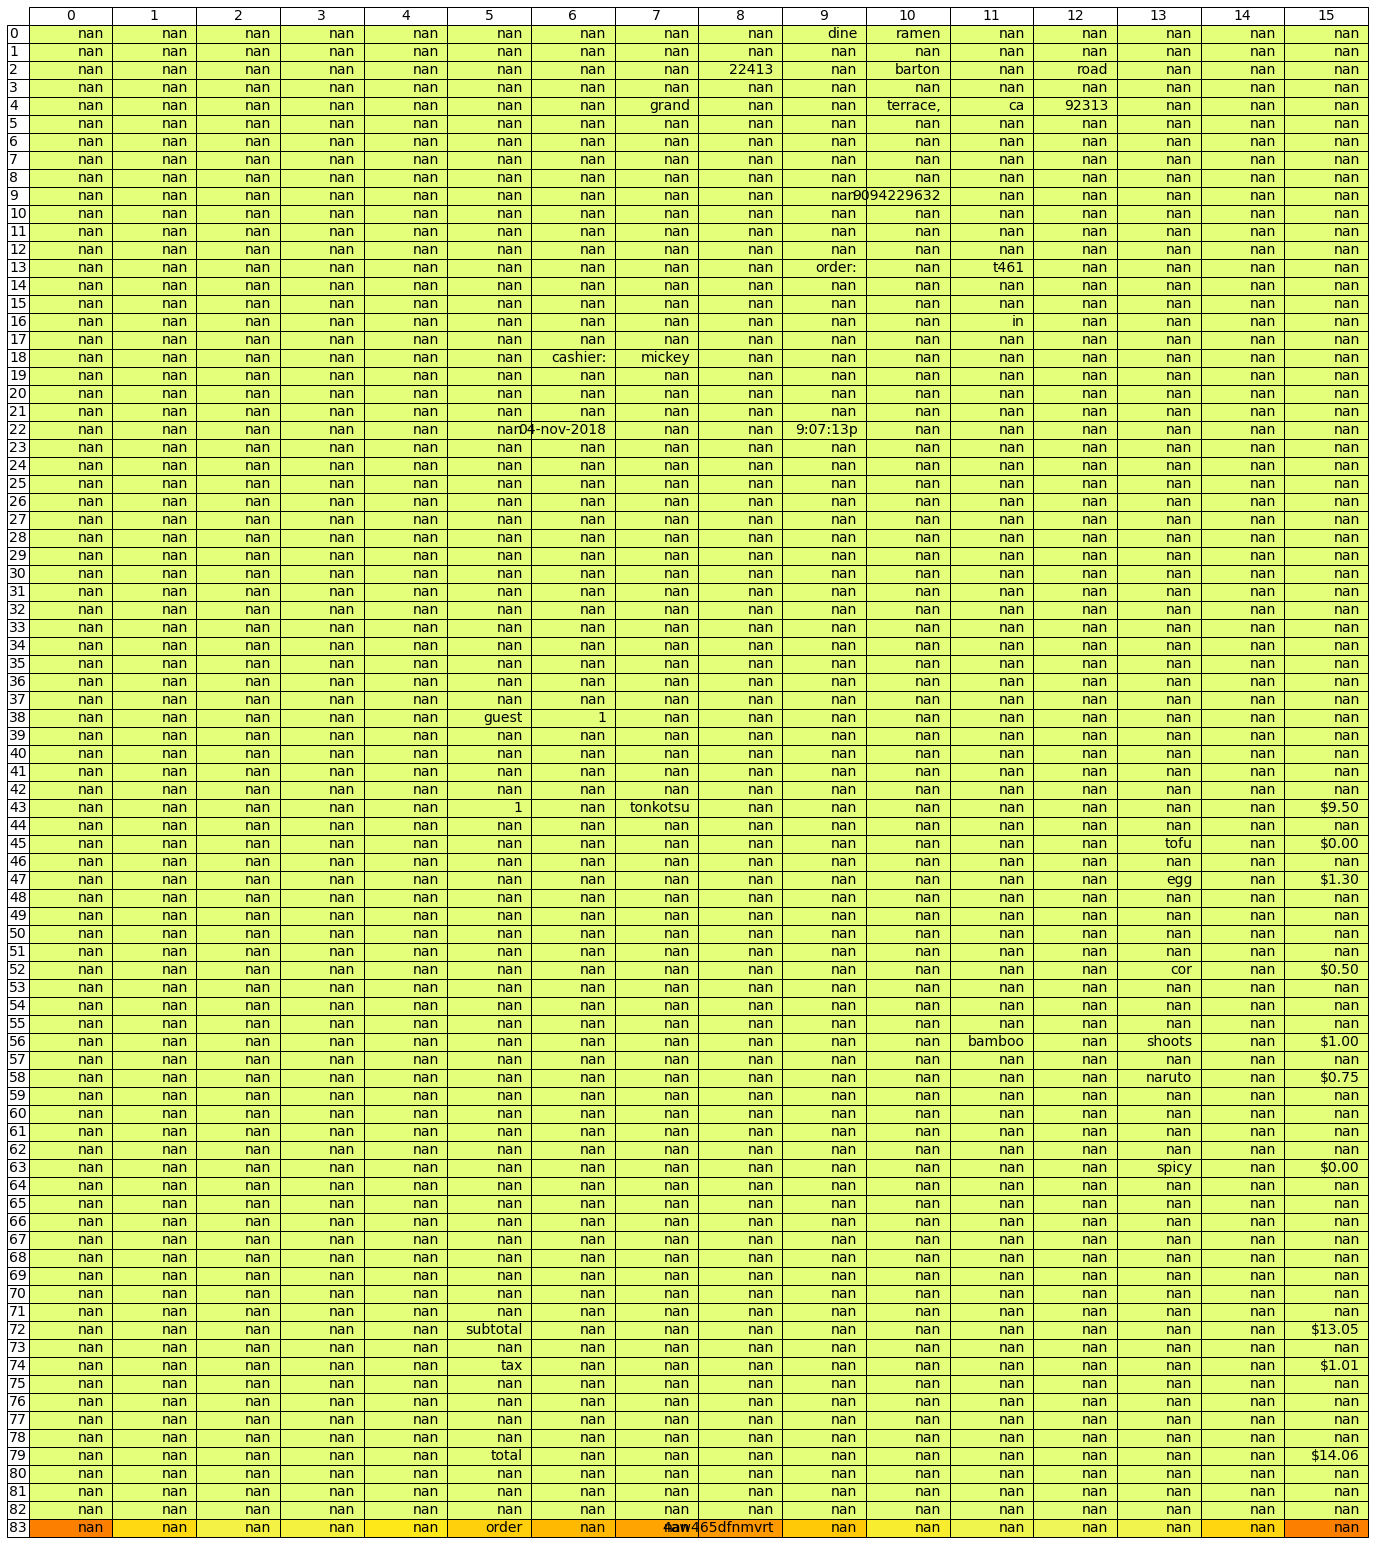

In [ ]:
# print the table of one test sample
untokenize_receipt(X_test[11])
grid2table(X_test[11],y_pred[11])

To extract the amount from the prediction, a threshold is required, 0.9 for example.

In [ ]:
a = 0.5
result = np.where(y_pred[10] > a) 

# Conclusion

The preprocessing allow to increase the quality of the OCR.

It provides 116 on 200 grid text receipt usable for the training.

The model need to predict the area where to find the amount, which is similar to the image segmentation purpose.
Here, we only have two classes, highly imbalanced (the amount is generaly one cell on the 83*15).

The model may need more hyparametrization and a bigger sample, but despite the border effet, we can see that a cell with text instead of NaN has a higher likelyhood of being an amount according to the model.

### To improve this result
- Enhance the quality of the image preprocessing, especially for skewed and blured receipts. The border detection, as intented in Annexe, may be a lead.
- Enhance the model.
- Try with other loss function (mean intersect on union, for example)
- Try with more sample for the training

# Annexe tools

In [ ]:
# get_max_size nb lines and nb rows from receipts:
maxrows = 0
maxcols = 0
for i in range(len(receipt)):
  print(i)
  extracted_text = get_best_OCR(receipt[i])
  splits = extracted_text.lower().splitlines()
  maxrows = max(len(splits), maxrows)
  for j in range(len(splits)):
    maxcols = max(len(splits[j].split(' ')),maxcols)
print('maxrows', maxrows,'maxcols', maxcols)

0


AttributeError: ignored

In [ ]:
# get mask from receipt (background 0, receipt 1)
from skimage import filters, morphology, measure
from scipy.ndimage.morphology import binary_fill_holes
def get_mask(grayscale):
  mask = filters.gaussian(grayscale, 2) > 0.6
  mask = morphology.binary_closing(mask, selem=morphology.disk(2, bool))
  mask = binary_fill_holes(mask, structure=morphology.disk(3, bool))
  mask = measure.label(mask)
  return (mask == 1 + np.argmax([r.filled_area for r in measure.regionprops(mask)]))

In [ ]:
#fig, axes = plt.subplots(1, 1, figsize=(24, 12))
mask = get_mask(grayscale)
plt.imshow(mask, cmap=plt.cm.gray) 
# show vertical and horizontal lines
ax = plt.gca()
for i in range(len(vertical)):
  plt.plot([vertical[i][0][0],vertical[i][1][0]],[vertical[i][0][1],vertical[i][1][1]], color='red')
for i in range(len(horizontal)):
  plt.plot([horizontal[i][0][0],horizontal[i][1][0]],[horizontal[i][0][1],horizontal[i][1][1]], color='green')
plt.show()

In [ ]:
# corner detection
from skimage import transform

#  shrinking the shapes of the mask
def get_mask_edges(mask):
  edges = mask ^ morphology.binary_erosion(mask, selem=morphology.disk(2, bool)) 
  # detecting lines with Hough transformation
  segments = np.array(transform.probabilistic_hough_line(edges))
  angles = np.array([np.abs(np.arctan2(a[1]-b[1], a[0]-b[0]) - np.pi/2) for a,b in segments])
  # sort segments to horizontals and verticals
  vertical = segments[angles < np.pi/4] 
  horizontal = segments[angles > np.pi/4]
  return (vertical, horizontal)

In [ ]:
def lineIntersection(s1, s2):
  xdiff = (s1[0][0] - s1[1][0], s2[0][0] - s2[1][0])
  ydiff = (s1[0][1] - s1[1][1], s2[0][1] - s2[1][1])

  def det(a, b):
      return a[0] * b[1] - a[1] * b[0]

  div = det(xdiff, ydiff)
  if div == 0:
      raise Exception('lines do not intersect')

  d = (det(*s1), det(*s2))
  x = det(d, xdiff) / div
  y = det(d, ydiff) / div
  return x, y

In [ ]:
from sklearn import cluster 
# get segments intersection
def get_seg_inter(vertical, horizontal):
  intersections = [lineIntersection(vs, hs) for vs in vertical for hs in horizontal]
  bw = cluster.estimate_bandwidth(intersections, 0.1)
  corners = cluster.MeanShift(bandwidth=bw).fit(intersections).cluster_centers_
  return corners

In [ ]:
# order corners to get polygone
def get_quadri_from4cornes(c):
  if len(c) != 4:
    raise Exception('need four points')
  next = []
  quadri = []
  first = c[0]
  # begin by the upper left
  meanx = np.mean([ci[0] for ci in c])
  meany = np.mean([ci[1] for ci in c])
  for ci in c:
    if (ci[0] < meanx) and (ci[1]<meany):
      first = ci
  # remove first from list c
  c = [a for a, skip in zip(c, [np.allclose(a, first) for a in c]) if not skip]
  curdist = 9999999
  # get closest point horizontaly
  for i in range(3):
    if abs(first[1] - c[i][1]) < curdist:
      curdist = abs(first[1] - c[i][1])
      next = c[i]
  #c.remove(next)
  c = [a for a, skip in zip(c, [np.allclose(a, next) for a in c]) if not skip]
  quadri.append([first,next])
  curc = next
  curdist = abs(curc[0] - c[0][0])
  # get closest point verticaly
  if (abs(curc[0] - c[1][0]) < curdist):
    quadri.append([next,c[1]])
    quadri.append([c[1],c[0]])
    quadri.append([c[0],first])
  else:
    quadri.append([next,c[0]])
    quadri.append([c[0],c[1]])
    quadri.append([c[1],first])    
  return np.array(quadri)

In [ ]:
import math
# get distance between segements
def dist_segs_h(s1,s2):
  s1_l, s1_r = (s1[0], s1[1]) if s1[0][0] < s1[1][0] else (s1[1], s1[0])
  s2_l, s2_r = (s2[0], s2[1]) if s2[0][0] < s2[1][0] else (s2[1], s2[0])
  return (math.sqrt((s1_l[0]-s2_l[0])**2 + (s1_l[1]-s2_l[1])**2) + math.sqrt((s1_r[0]-s2_r[0])**2 + (s1_r[1]-s2_r[1])**2))

def dist_segs_v(s1,s2):
  s1_t, s1_b = (s1[0], s1[1]) if s1[0][1] < s1[1][1] else (s1[1], s1[0])
  s2_t, s2_b = (s2[0], s2[1]) if s2[0][1] < s2[1][1] else (s2[1], s2[0])
  # distance between the 2 tops + distance between the two bottoms
  return (math.sqrt((s1_t[0]-s2_t[0])**2 + (s1_t[1]-s2_t[1])**2) + math.sqrt((s1_b[0]-s2_b[0])**2 + (s1_b[1]-s2_b[1])**2))

In [ ]:
# get best quadrilatere from all possible 
def get_best_quad(vertical, horizontal, corners):
  # class borders into left, right, top and bottom
  meanv = np.array([v[0][0] for v in vertical]).mean()
  leftsegs = [v for v in vertical if v[0][0] < meanv]
  rightsegs = [v for v in vertical if v[0][0] > meanv]
  meanh = np.array([h[0][1] for h in horizontal]).mean()
  topsegs = [h for h in horizontal if h[0][1] < meanh]
  bottomsegs = [h for h in horizontal if h[0][1] > meanh]
  # chose the 4 corners witch fit best to the edge segments
  nb_corners = len(corners)
  nb = 0
  best_quad = []
  best_distance = 99999999999999999999
  aream = sum(sum(mask)) 
  for i in range(nb_corners-3):
    for j in range(i+1, nb_corners-2):
      for k in range(j+1, nb_corners-1):
        for l in range(k+1, nb_corners):
          segs = get_quadri_from4cornes([corners[i], corners[j], corners[k], corners[l]])
          # sort segments to horizontals and verticals
          # vertical
          if segs[1][0][0] < segs[3][0][0]:
            left = segs[1]
            right = segs[3]
          else:
            left = segs[3]
            right = segs[1]
          if segs[0][0][1] < segs[2][0][1]:
            top = segs[0]
            bottom = segs[2]
          else:
            top = segs[2]
            bottom = segs[0]
          # try with area
           
          meanvert = (math.sqrt((left[0][0]+left[1][0])**2 + (left[0][1]+left[1][1])**2)+math.sqrt((right[0][0]+right[1][0])**2 + (right[0][1]+right[1][1])**2))/2
          meanhoriz = (math.sqrt((top[0][0]+top[1][0])**2 + (top[0][1]+top[1][1])**2)+math.sqrt((bottom[0][0]+bottom[1][0])**2 + (bottom[0][1]+bottom[1][1])**2))/2
          #curarea = meanvert * meanhoriz
          distance = (sum([dist_segs_v(left, l) for l in leftsegs]) + 
                      sum([dist_segs_v(right, r) for r in rightsegs]) + 
                      sum([dist_segs_h(top, t) for t in topsegs]) + 
                      sum([dist_segs_h(bottom, b) for b in bottomsegs]))
          if distance < best_distance:
          #if abs(aream - curarea) < best_distance:
            best_distance =  distance # abs(aream - curarea)
            best_quad = segs

          nb +=1         
  return best_quad

In [ ]:
from scipy.spatial import distance

# cropping according to the best quadrilatere
def crop_unskew_im(grayscale, quad):
  coords = np.array([best_quad[0][0], best_quad[1][0], best_quad[2][0], best_quad[3][0]] )
  d = distance.pdist(coords)
  w = int(max(d[0], d[5])) # = max(dist(p1, p2), dist(p3, p4))
  h = int(max(d[2], d[3])) # = max(dist(p1, p4), dist(p2, p3))
  
  tr = transform.ProjectiveTransform()
  tr.estimate(np.array([[0,0], [w,0], [w,h], [0,h]]), coords)
  receiptcrop = transform.warp(grayscale, tr, output_shape=(h, w), order=1, mode="reflect")
  return receiptcrop

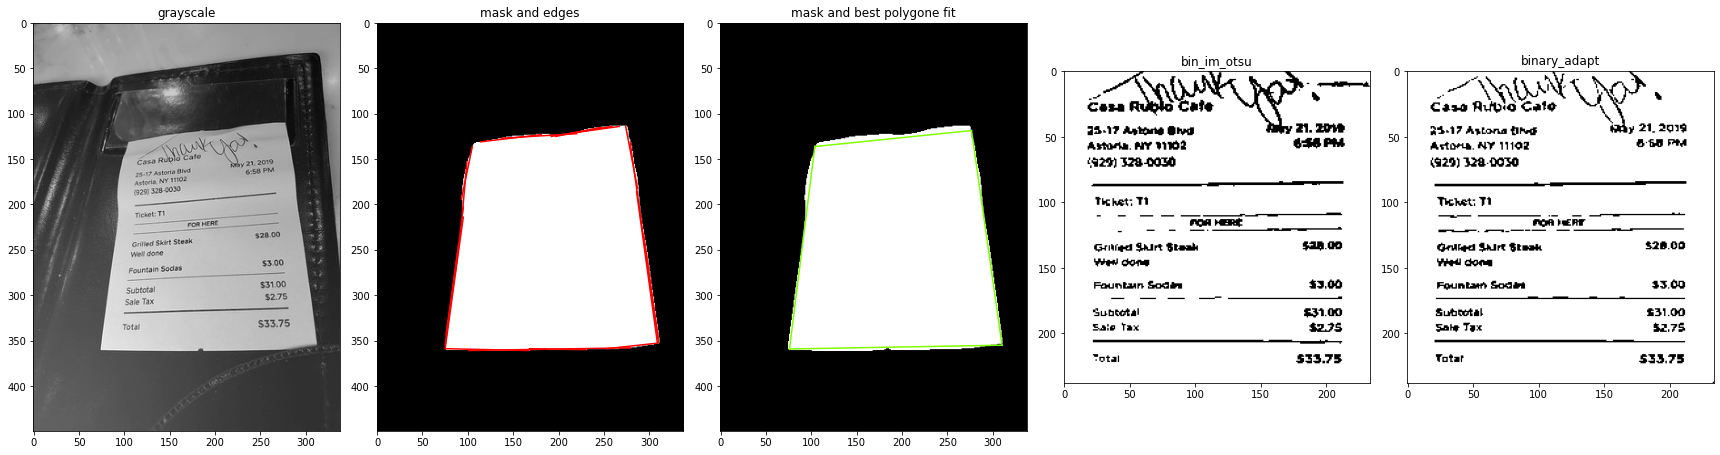

In [ ]:
# show image
from scipy.fftpack import dct, idct
# get image in grayscale
gray = rgb2gray(receipt[167])
frequencies = dct(dct(gray, axis=0), axis=1)
frequencies[:2,:2] = 0
gray = idct(idct(frequencies, axis=1), axis=0)
 
gray = (gray - gray.min()) / (gray.max() - gray.min()) # renormalize to range [0:1]
# get mask
mask = get_mask(gray)
# get mask edges
vertical, horizontal = get_mask_edges(mask)
# get all edges intersections: all corners
corners = get_seg_inter(vertical, horizontal)
# chose the best quadrilatere from all 4 corners possibles set
best_quad = get_best_quad(vertical, horizontal, corners)
# crop the image according to this best quadrilatere
crop_im = crop_unskew_im(gray, best_quad)
## binarize image
# otsu threshold
thresh = min(threshold_otsu(crop_im), crop_im.mean())
bin_otsu = crop_im > thresh
# local threshold (adaptative)
block_size = 35
ad_thresh = threshold_local(crop_im, block_size, offset=0.1)
binary_local = crop_im > ad_thresh

fig, axes = plt.subplots(1, 5, figsize=(24, 12))
ax = axes.ravel()
ax[0].imshow(gray, cmap=plt.cm.gray) # grayscale
ax[0].set_title("grayscale")
ax[1].imshow(mask, cmap=plt.cm.gray) 
# show vertical and horizontal lines
for i in range(len(vertical)):
  ax[1].plot([vertical[i][0][0],vertical[i][1][0]],[vertical[i][0][1],vertical[i][1][1]], color='red')
for i in range(len(horizontal)):
  ax[1].plot([horizontal[i][0][0],horizontal[i][1][0]],[horizontal[i][0][1],horizontal[i][1][1]], color='red')
ax[1].set_title("mask and edges")
ax[2].imshow(mask, cmap=plt.cm.gray) 
# show best quad
for i in range(4):
  ax[2].plot([best_quad[i][0][0],best_quad[i][1][0]],[best_quad[i][0][1],best_quad[i][1][1]], color='chartreuse')
ax[2].set_title("mask and best polygone fit")
ax[3].imshow(bin_otsu, cmap=plt.cm.gray) # crop_im
ax[3].set_title("bin_im_otsu")
ax[4].imshow(binary_local, cmap=plt.cm.gray) # binary_local
ax[4].set_title("binary_adapt")
fig.tight_layout()
plt.show()

In [ ]:
#area
sum(sum(mask))

In [ ]:
extracted_text = pytesseract.image_to_string(binary_a2)
splits = extracted_text.lower().splitlines()
toto = get_ocr_nona(binary_a2, splits)
toto

In [ ]:
# optimize best OCR
import time
t0 = time.time()
pytesseract.image_to_data(binary_adaptive, output_type='data.frame')
t1 = time.time()
print("to data took %0.2f seconds"% (t1 - t0))
t0 = time.time()
pytesseract.image_to_string(binary_adaptive)
t1 = time.time()
print("string to data took %0.2f seconds"% (t1 - t0))

In [ ]:
import keras.backend as K
# Mean Intersection-Over-Union 
def iou_loss_core(y_true, y_pred, smooth=1):
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    union = K.sum(y_true,-1) + K.sum(y_pred,-1) - intersection
    iou = (intersection + smooth) / ( union + smooth)
    return iou